In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [3]:
train_dir = '/content/drive/MyDrive/IA 2/Proyecto_IA2/Bone Break Classification/train'
test_dir = '/content/drive/MyDrive/IA 2/Proyecto_IA2/Bone Break Classification/test'


def preprocess_image(image):
    # Convertir a escala de grises y luego expandir a tres canales para mantener la consistencia
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_image
)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_image)

# Cargar los datos desde las carpetas
train_generator = train_datagen.flow_from_directory(
    train_dir,   # Ruta a las imágenes de entrenamiento
    target_size=(128, 128),      # Tamaño de las imágenes
    batch_size=32,
    class_mode='categorical'     # Asume múltiples clases (más de 2)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,    # Ruta a las imágenes de prueba
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 703 images belonging to 6 classes.
Found 91 images belonging to 6 classes.


In [6]:
# Cargar el modelo base VGG16 preentrenado
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Congelar las capas del modelo base
base_model.trainable = False

# Añadir las capas personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x)       # Pooling global
x = BatchNormalization()(x)           # Normalización
x = Dropout(0.5)(x)                   # Regularización
x = Dense(256, activation='relu')(x)  # Capa totalmente conectada
x = Dropout(0.3)(x)                   # Regularización adicional
output = Dense(6, activation='softmax')(x)  # Capa de salida para 6 clases

In [7]:
# Construir el modelo final
model = Model(inputs=base_model.input, outputs=output)

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,    # Ajusta según sea necesario
    verbose=1
)

# Evaluación del modelo en el conjunto de prueba
loss, accuracy = model.evaluate(test_generator)
print(f'Pérdida en el conjunto de prueba: {loss}')
print(f'Precisión en el conjunto de prueba: {accuracy}')

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.1895 - loss: 1.8351 - val_accuracy: 0.1648 - val_loss: 1.9499
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.1995 - loss: 1.8135 - val_accuracy: 0.1209 - val_loss: 1.8983
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.2136 - loss: 1.7695 - val_accuracy: 0.1209 - val_loss: 1.8597
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.1876 - loss: 1.7969 - val_accuracy: 0.1538 - val_loss: 1.8367
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.2288 - loss: 1.7787 - val_accuracy: 0.1319 - val_loss: 1.8225
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.2104 - loss: 1.7636 - val_accuracy: 0.1209 - val_loss: 1.8162
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2285 - loss: 1.7505 - val_accuracy: 0.1099 - val_loss: 1.8089
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2486 - loss: 1.7282 - val_accuracy: 0.1758 - val_loss:

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.2083 - loss: 1.7676
Pérdida: 1.7702, Precisión: 0.2031
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
                       precision    recall  f1-score   support

    Avulsion fracture       0.15      0.14      0.15        14
  Comminuted fracture       0.17      0.50      0.25        14
 Fracture Dislocation       0.39      0.47      0.43        19
  Greenstick fracture       0.08      0.06      0.07        16
    Hairline Fracture       0.00      0.00      0.00        10
Pathological fracture       0.00      0.00      0.00        18

             accuracy                           0.21        91
            macro avg       0.13      0.20      0.15        91
         weighted avg       0.15      0.21      0.16        91



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


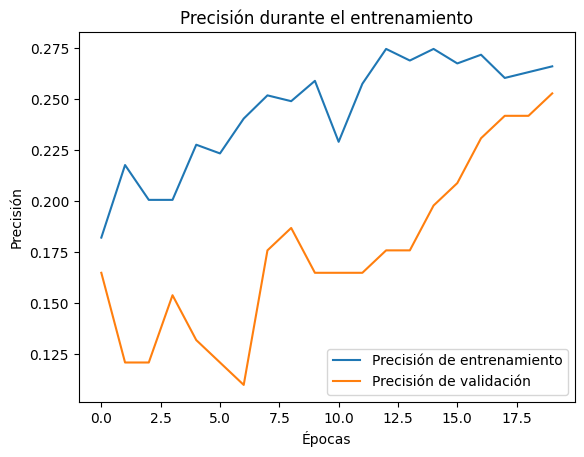

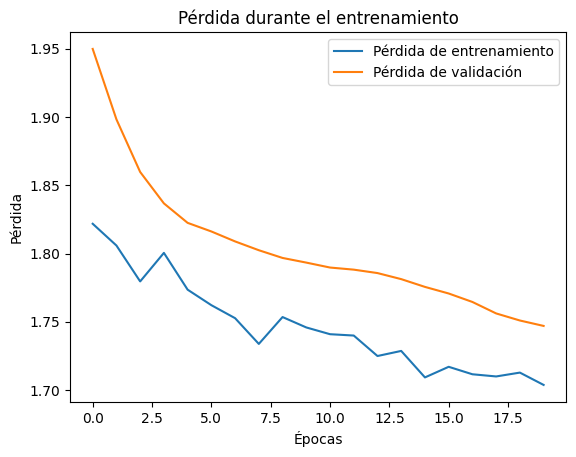

In [8]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Pérdida: {loss:.4f}, Precisión: {accuracy:.4f}')

# Obtener predicciones y etiquetas verdaderas
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las predicciones en clases
y_true = test_generator.classes[:len(y_pred_classes)]  # Asegurar que y_true y y_pred_classes tengan el mismo tamaño

# Generar el reporte de clasificación
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

# Graficar precisión durante el entrenamiento
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.show()

# Graficar pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()


In [9]:
# Descongelar las últimas capas del modelo base
for layer in base_model.layers[-10:]:  # Descongelar las últimas 10 capas
    layer.trainable = True

# Compilar nuevamente con un learning rate más bajo
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Reentrenar el modelo
history_fine = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=test_generator.samples // test_generator.batch_size
)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.1729 - loss: 3.0269 - val_accuracy: 0.1406 - val_loss: 1.9733
Epoch 2/10
 1/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.1875 - loss: 2.3628

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 185ms/step - accuracy: 0.1875 - loss: 2.3628 - val_accuracy: 0.2222 - val_loss: 1.8113
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.1979 - loss: 2.7901 - val_accuracy: 0.1406 - val_loss: 2.0350
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.1250 - loss: 2.8858 - val_accuracy: 0.1852 - val_loss: 1.9077
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.2256 - loss: 2.6064 - val_accuracy: 0.1562 - val_loss: 2.1055
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - accuracy: 0.2812 - loss: 1.8560 - val_accuracy: 0.1481 - val_loss: 2.1790
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.2243 - loss: 2.5419 - val_accuracy: 0.1250 - val_loss: 2.4784
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.0625 - loss: 2.9890 - val_accuracy: 0.2222 - val_loss: 2.2093
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.2687 - loss: 2.4435 - val_accuracy: 0.1719 - val_loss: 2.5

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.1875 - loss: 2.5741
Pérdida: 2.5379, Precisión: 0.1875
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                       precision    recall  f1-score   support

    Avulsion fracture       0.00      0.00      0.00        14
  Comminuted fracture       0.15      0.86      0.25        14
 Fracture Dislocation       0.22      0.11      0.14        19
  Greenstick fracture       0.00      0.00      0.00        16
    Hairline Fracture       0.00      0.00      0.00        10
Pathological fracture       0.00      0.00      0.00        18

             accuracy                           0.15        91
            macro avg       0.06      0.16      0.07        91
         weighted avg       0.07      0.15      0.07        91



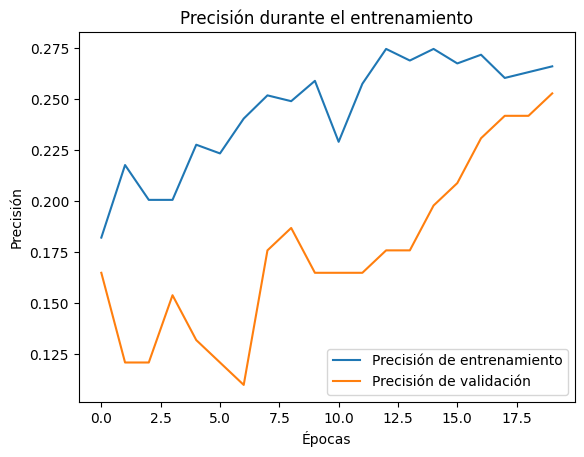

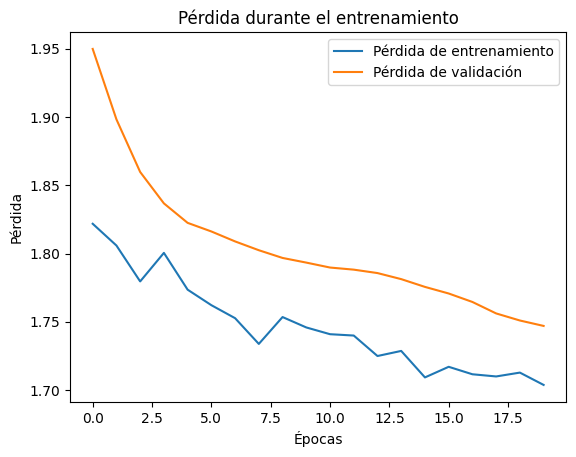

In [10]:
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt

# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Pérdida: {loss:.4f}, Precisión: {accuracy:.4f}')

# Obtener predicciones y etiquetas verdaderas
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convertir las predicciones en clases
y_true = test_generator.classes[:len(y_pred_classes)]  # Asegurar que y_true y y_pred_classes tengan el mismo tamaño

# Generar el reporte de clasificación
class_names = list(test_generator.class_indices.keys())  # Nombres de las clases
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

# Graficar precisión durante el entrenamiento
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento')
plt.show()

# Graficar pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento')
plt.show()